# Section 0: Preliminaries
All the required libraries are imported in the cell below.

   The ten armed bandit enviroment will be used for this assignment. 10-armed test bed was introduced in in section 2.3 of S&B's Intro to RL. It has 10 arms, which are the actions the agent can take. Pulling an arm generates a stochastic reward from a Gaussian distribution with unit variance. For each action, the expected value of that action in randomly sampled from a normal distribution, at the start of each run.   

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env
from tqdm import tqdm
import time

# Section 1: Greedy Agent
Our objective is to create an agent that will find the action with highest expected reward. One way the agent could operate is to always choose the action with the value based on the agent's current estimates. An agent that chooses such action is called as a greedy agent.

### Argmax
The argmax function below is different from the numpy's argmax. Numpy's argmax returns the first instance of the highest value in the array and ignores other ties. This introdcues bias in the decisions taken by the agent. 
The function below choses random instance of the highest value present in case of ties.

In [2]:
def argmax(q_values):
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = [i]
        elif q_values[i] == top:
            ties.append(i)
            
    return ties[np.random.choice(len(ties))]

In [3]:
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8

test_array = [1, 0, 0, 1]
total = 0

for i in range(100):
    total += argmax(test_array)

assert total > 0
assert total != 300

In [4]:
def test_argmax():
    test_array = [1, 0, 0, 1]
    total = 0
    for i in range(100):
        total += argmax(test_array)
        
    np.save("argmax_test", total)
    return total
test_argmax()

165

In [5]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        current_action = argmax(self.q_values)
        self.arm_count[self.last_action] += 1
        step_size = 1 / self.arm_count[self.last_action]
        old_estimate = self.q_values[self.last_action]
        self.q_values[self.last_action] = old_estimate + step_size * (reward - old_estimate)
        
        self.last_action = current_action
        
        return current_action

In [6]:
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1
action = greedy_agent.agent_step(1, 0)
np.save("greedy_test", greedy_agent.q_values)
print("Output:")
print(greedy_agent.q_values)
print("Expected Output:")
print([0, 0.5, 1.0, 0, 0])

assert action == 2
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


100%|██████████| 200/200 [00:10<00:00, 19.58it/s]


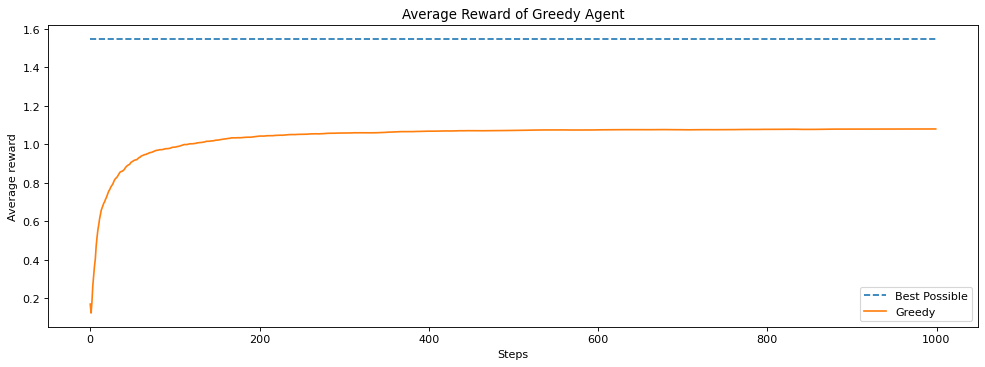

In [7]:


# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
env = ten_arm_env.Environment     # We the environment to use
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # Pass the agent the information it needs; 
                                  # here it just needs the number of actions (number of arms).
env_info = {}                     # Pass the environment the information it needs; in this case, it is nothing.

all_averages = []

for i in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
np.save("greedy_scores", greedy_scores)



# Section 2: Epsilon-Greedy Agent
Another way for the agent to operate is to not take the greedy action always. Instead, sometimes it takes an exploratory action. It does this so that it can find out what the best action is. If we always choose what we think is the best current action is, we may miss out on the true best action, because we haven't explored enough to find the best action.

In [8]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        if np.random.random() < self.epsilon:
            current_action = np.random.randint(0, len(self.q_values))
        else:
            current_action = argmax(self.q_values)
            
        self.arm_count[self.last_action] += 1
        step_size = 1 / self.arm_count[self.last_action]
        old_estimate = self.q_values[self.last_action]
        self.q_values[self.last_action] = old_estimate + step_size * (reward - old_estimate)
        
        self.last_action = current_action
        
        return current_action

In [9]:
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(1, 0)
print("Output:")
print(e_greedy_agent.q_values)
print("Expected Output:")
print([0, 0.5, 1.0, 0, 0])

# assert action == 2, "Check that you are using argmax to choose the action with the highest value."
assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0], "Check that you are updating q_values correctly."

Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


100%|██████████| 200/200 [00:10<00:00, 18.26it/s]


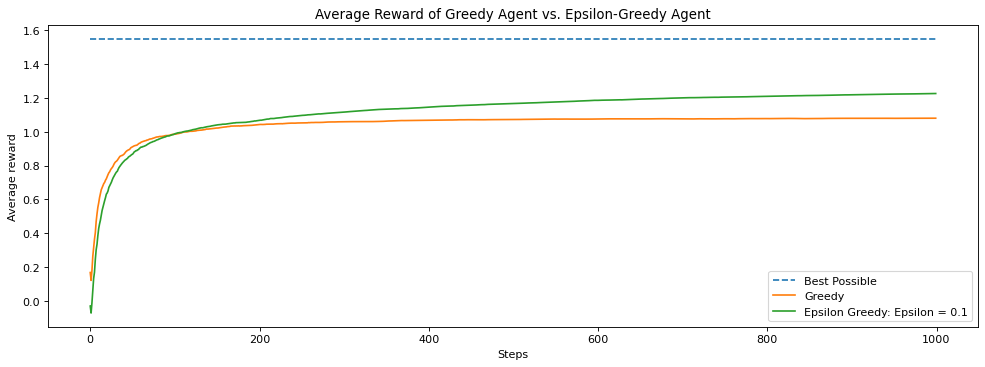

In [10]:
#Plot Epsilon Greedy and Greedy results
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for i in tqdm(range(num_runs)):
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()
    
    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step()
        
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)
    
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. Epsilon-Greedy Agent")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Best Possible", "Greedy", "Epsilon Greedy: Epsilon = 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
np.save("e-greedy", all_averages)

### Averaging Multiple Runs


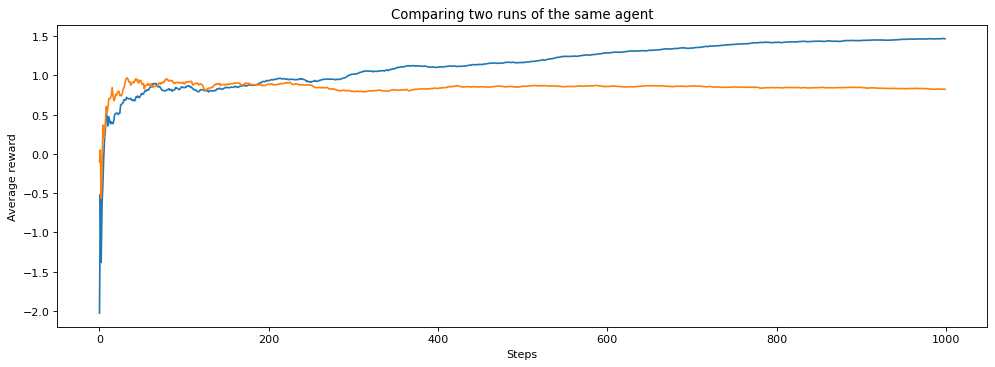

In [11]:
# Plot runs of e-greedy agent
agent = EpsilonGreedyAgent
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
#     all_averages.append(averages)
    plt.plot(averages)

# plt.plot(greedy_scores)
plt.title("Comparing two runs of the same agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
# plt.plot(np.mean(all_averages, axis=0))
# plt.legend(("Greedy", "Epsilon: 0.1"))
plt.show()



In [12]:
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")
    

print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")

Random Seed 1
Exploratory Action
Exploratory Action
Exploratory Action


Random Seed 2
Exploratory Action


# Section 3: Comparying values of Epsilon

100%|██████████| 200/200 [00:08<00:00, 22.55it/s]


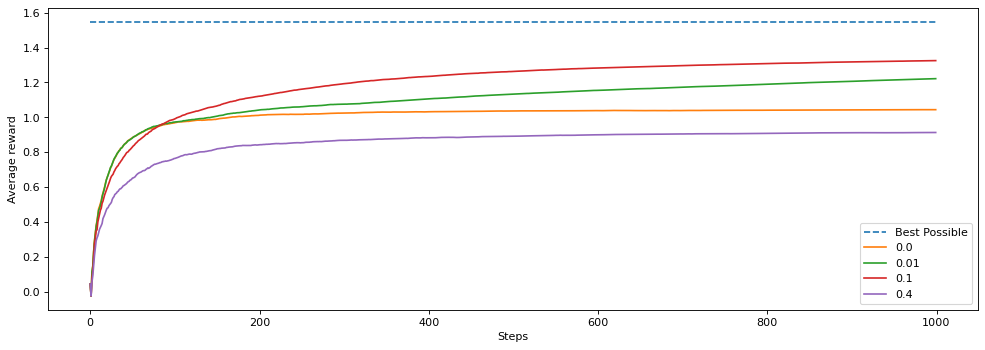

In [13]:
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions" : 10, "epsilon" : epsilon}
        env_info = {"random_seed": run}
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)
        
        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1]+reward)
            averages.append(scores[-1]/(i+1))
            
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

# Section 4: Effect of Step Size

In [14]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        if np.random.random() < self.epsilon:
            current_action = np.random.randint(0, len(self.q_values))
        else:
            current_action = argmax(self.q_values)
            
        self.arm_count[self.last_action] += 1
        old_estimate = self.q_values[self.last_action]
        self.q_values[self.last_action] = old_estimate + self.step_size * (reward - old_estimate)
        
        self.last_action = current_action
        
        return current_action

In [15]:
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    # e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    print("Output for step size: {}".format(step_size))
    print(e_greedy_agent.q_values)
    print("Expected Output:")
    print([0, step_size, 1.0, 0, 0])
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Check that you are updating q_values correctly using the stepsize."

Output for step size: 0.01
[0, 0.01, 1.0, 0, 0]
Expected Output:
[0, 0.01, 1.0, 0, 0]
Output for step size: 0.1
[0, 0.1, 1.0, 0, 0]
Expected Output:
[0, 0.1, 1.0, 0, 0]
Output for step size: 0.5
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]
Output for step size: 1.0
[0, 1.0, 1.0, 0, 0]
Expected Output:
[0, 1.0, 1.0, 0, 0]


100%|██████████| 200/200 [00:10<00:00, 18.76it/s]
C:\Users\anura\.conda\envs\torch\lib\site-packages\ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


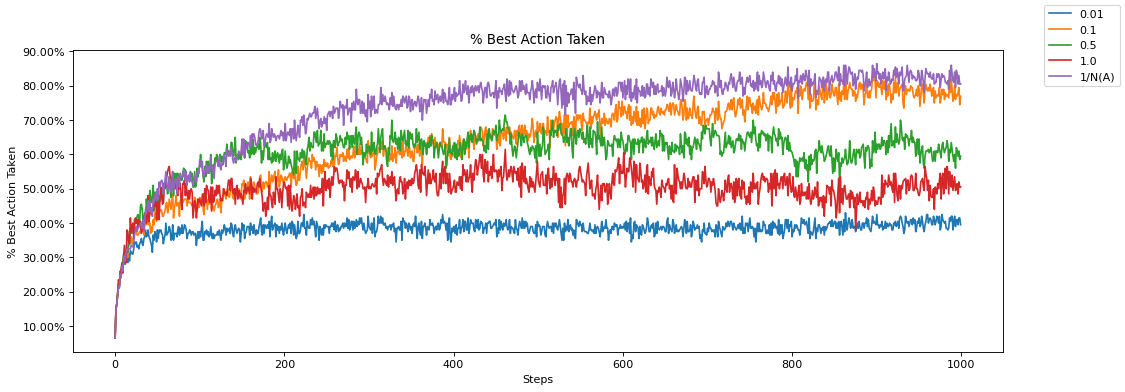

In [16]:
step_sizes = [0.01, 0.1, 0.5, 1.0]

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgentConstantStepsize
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))
    if step_size == 0.01:
        np.save("step_size", best_actions[step_size])
    
ax.plot(np.mean(n_best_actions, axis=0))
fig.legend(step_sizes + ["1/N(A)"])
plt.title("% Best Action Taken")
plt.xlabel("Steps")
plt.ylabel("% Best Action Taken")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

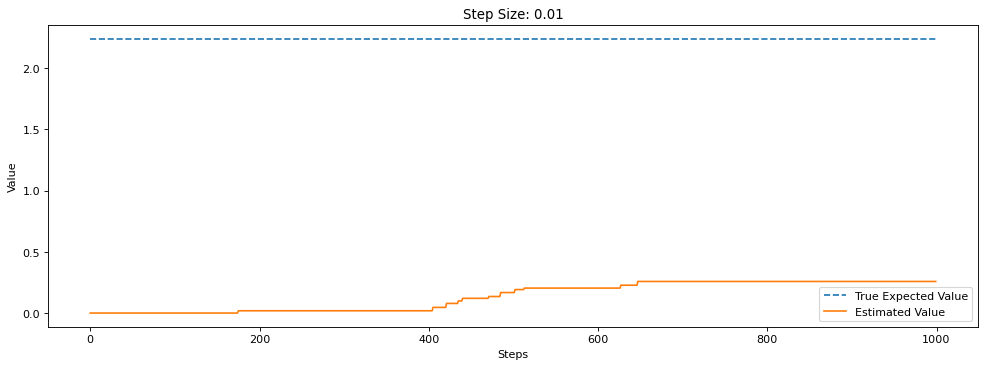

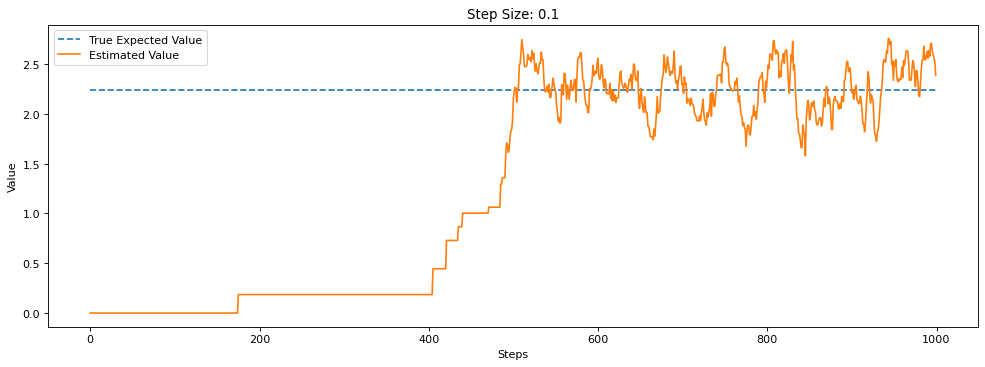

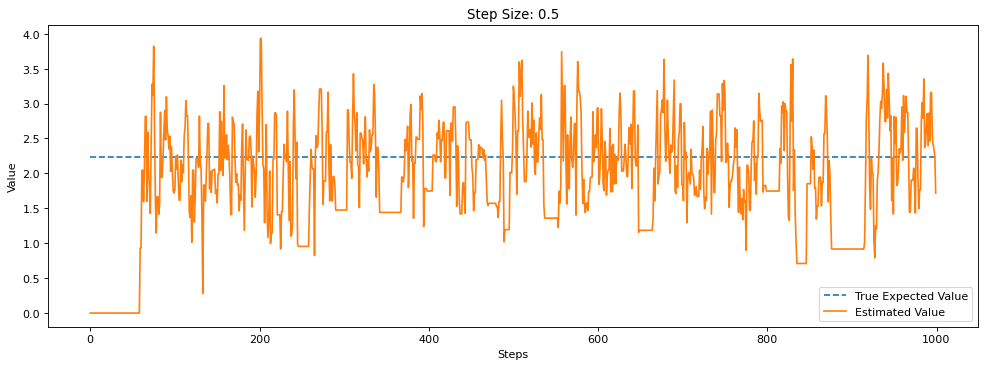

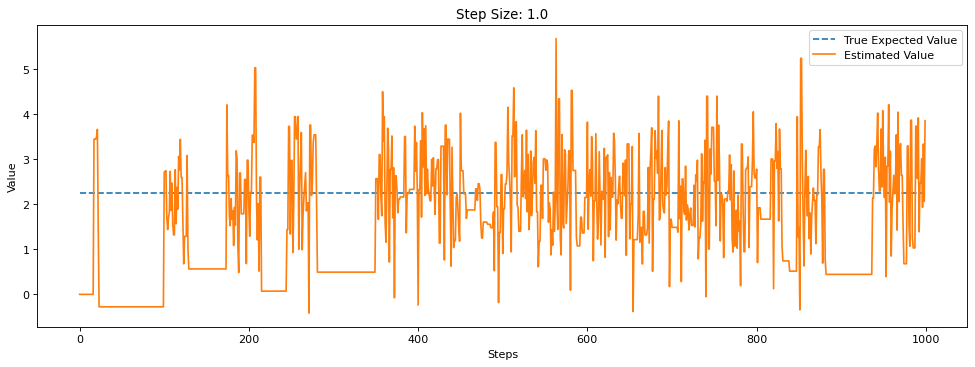

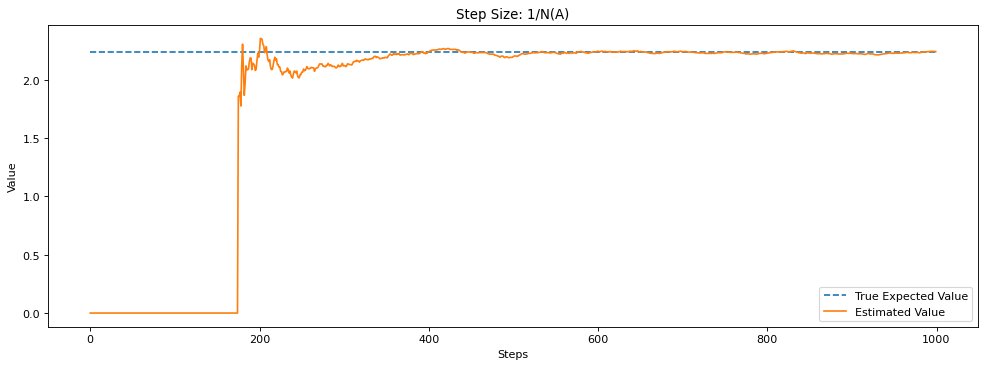

In [17]:
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Step Size: 1/N(A)")
plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
plt.plot(np.array(n_q_values)[:, largest])
plt.legend(["True Expected Value", "Estimated Value"])
plt.xlabel("Steps")
plt.ylabel("Value")
plt.show()